# Setup

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
import skimage
from skimage import measure, io
import pandas as pd
import seaborn as sns

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [35]:
from tomo2seg.data import VOLUME_PRECIPITATES_V1 as VOL_NAME_VERSION
logger.debug(f"{VOL_NAME_VERSION=}")

[2020-11-13::15:33:20.507] tomo2seg :: DEBUG :: {<ipython-input-35-626a1365fa0c>:<module>:002}
VOL_NAME_VERSION=('PA66GF30', 'v1')



In [36]:
logger.setLevel(logging.DEBUG)

In [37]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Load from the disk

In [38]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    volume_name := VOL_NAME_VERSION[0], 
    volume_version := VOL_NAME_VERSION[1]
)
logger.info(f"{volume=}")

hst_read = lambda x: functools.partial(
    # from pymicro
    file_utils.HST_read,
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x))  # it doesn't accept paths...

blobs_path_prefix = str(volume.versioned_labels_path("original"))[:-4]
logger.debug(f"{blobs_path_prefix=}")

[2020-11-13::15:33:20.677] tomo2seg :: DEBUG :: {data.py:with_check:214}
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

[2020-11-13::15:33:20.698] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

[2020-11-13::15:33:20.726] tomo2seg :: WARNING :: {data.py:with_check:236}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

[2020-11-13::15:33:20.727] tomo2seg :: DEBUG :: {data.py:metadata:171}
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

[2020-11-13::15:33:20.741] tomo2seg :: INFO :: {<ipython-input-38-4fefebe63d9f>:<module>:008}
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1299], 'y_range': [

# Porosity blobs

## z-axis 2d blobs

**Note about the filenames here**

Search for (Ctrl + F) `[filenames]` in the script `compute_2d_blob_props.py` to see where they come from.

In [39]:
filename = f"{blobs_path_prefix}.porosity.z-blobs.csv"
logger.debug(f"{filename=}")

astype_map = {"area": int, "centroid-0": int, "centroid-1": int, "slice_idx": int}
rename_map = {"Unnamed: 0": "index", "centroid-0": "centroid-x", "centroid-1": "centroid-y", "slice_idx": "z"}
blobsdf = pd.read_csv(filename).astype(astype_map).rename(columns=rename_map).set_index("index")

logger.debug(f"{blobsdf.shape}")

blobsdf["aspect_ratio"] = blobsdf.major_axis_length / blobsdf.minor_axis_length

[2020-11-13::15:33:20.830] tomo2seg :: DEBUG :: {<ipython-input-39-902b0e275b61>:<module>:002}
filename='/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels-original.porosity.z-blobs.csv'

[2020-11-13::15:33:22.293] tomo2seg :: DEBUG :: {<ipython-input-39-902b0e275b61>:<module>:008}
(797696, 22)



In [40]:
blobsdf.head(10).T

index,0,1,2,3,4,5,6,7,8,9
label,2.0,2.0000,2.000000,2.00000,2.000000,2.00,2.000000,2.00,2.000000,2.000000
area,1.0,33.0000,21.000000,9.00000,5.000000,2.00,11.000000,4.00,22.000000,25.000000
bbox-0,0.0,0.0000,2.000000,2.00000,2.000000,4.00,9.000000,9.00,19.000000,26.000000
bbox-1,0.0,37.0000,496.000000,517.00000,854.000000,884.00,269.000000,458.00,96.000000,733.000000
bbox-2,1.0,4.0000,9.000000,6.00000,5.000000,6.00,13.000000,11.00,25.000000,30.000000
bbox-3,1.0,47.0000,502.000000,520.00000,857.000000,885.00,273.000000,460.00,108.000000,741.000000
bbox_area,1.0,40.0000,42.000000,12.00000,9.000000,2.00,16.000000,4.00,72.000000,32.000000
centroid-x,0.0,1.0000,5.000000,3.00000,3.000000,4.00,10.000000,9.00,21.000000,27.000000
centroid-y,0.0,41.0000,498.000000,518.00000,855.000000,884.00,270.000000,458.00,101.000000,737.000000
eccentricity,0.0,0.9126,0.940400,0.86100,0.787000,1.00,0.602000,0.00,0.989300,0.890600


In [41]:
blobsdf.describe().T

,count,mean,std,min,25%,50%,75%,max
label,797696.0,2.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.00
area,797696.0,16.200927,22.410923,1.00000,5.000000,9.000000,19.000000,1022.00
bbox-0,797696.0,711.759041,354.005802,0.00000,474.000000,692.000000,1013.000000,1299.00
bbox-1,797696.0,514.634273,300.258004,0.00000,256.000000,510.000000,771.000000,1039.00
bbox-2,797696.0,715.384426,353.880388,1.00000,477.000000,697.000000,1017.000000,1300.00
bbox-3,797696.0,520.769208,300.509496,1.00000,262.000000,513.000000,777.000000,1040.00
bbox_area,797696.0,28.794620,59.478882,1.00000,6.000000,12.000000,32.000000,6132.00
centroid-x,797696.0,712.882537,354.058073,0.00000,474.000000,694.000000,1014.000000,1299.00
centroid-y,797696.0,516.945463,300.437343,0.00000,258.000000,510.000000,773.000000,1039.00
eccentricity,797696.0,0.856183,0.203097,0.00000,0.816400,0.919400,0.974000,1.00


CPU times: user 5.04 s, sys: 193 ms, total: 5.23 s
Wall time: 5.24 s


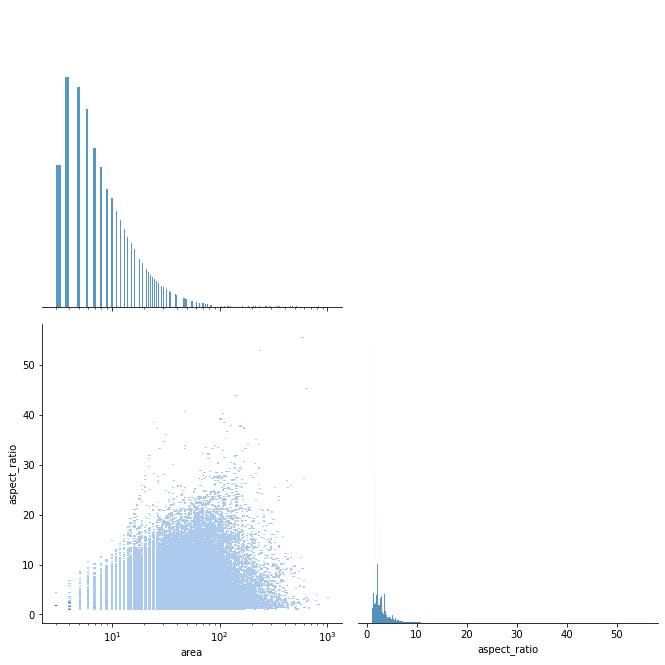

In [42]:
%%time
n = None
df = blobsdf.iloc[:n] if n is not None else blobsdf

pairgrid = sns.pairplot(
    df.replace([np.inf, -np.inf], np.nan).dropna(),
    vars=["area", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 10, sz))

CPU times: user 4.45 s, sys: 170 ms, total: 4.62 s
Wall time: 4.63 s


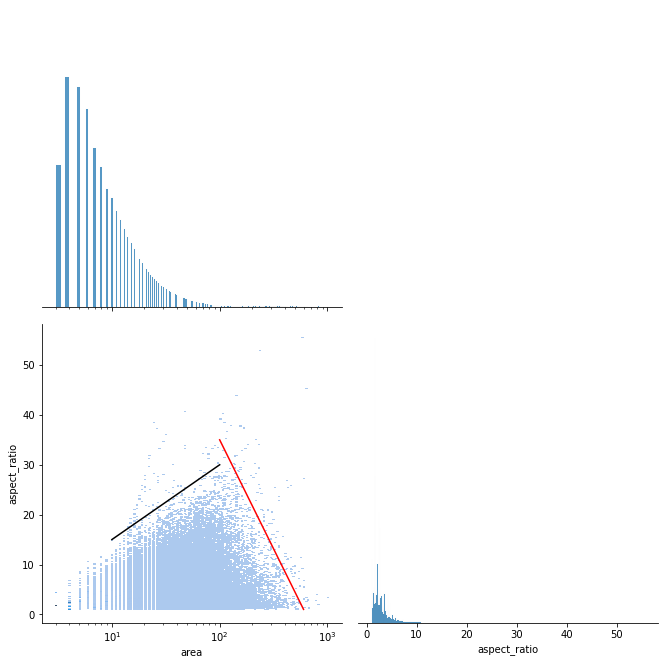

In [56]:
%%time
n = None
df = blobsdf
df = df.iloc[:n] if n is not None else df

line_points = (
    (100, 35),
    (600, 1),
)

line_points_2 = (
    (10, 15),
    (100, 30),
)

pairgrid = sns.pairplot(
    df.replace([np.inf, -np.inf], np.nan).dropna(),
    vars=["area", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 10, sz))

pairgrid.axes[1, 0].plot(*zip(*line_points), c='r')
pairgrid.axes[1, 0].plot(*zip(*line_points_2), c='k')

In [62]:
m2 = (line_points_2[1][1] - line_points_2[0][1]) / (np.log10(line_points_2[1][0]) - np.log10(line_points_2[0][0]))
b2 = line_points_2[0][1] - m2 * np.log10(line_points_2[0][0])
m2, b2

(15.0, 0.0)

In [63]:
m = (line_points[1][1] - line_points[0][1]) / (np.log10(line_points[1][0]) - np.log10(line_points[0][0]))
b = line_points[0][1] - m * np.log10(line_points[0][0])
m, b

(-43.69330510390795, 122.3866102078159)

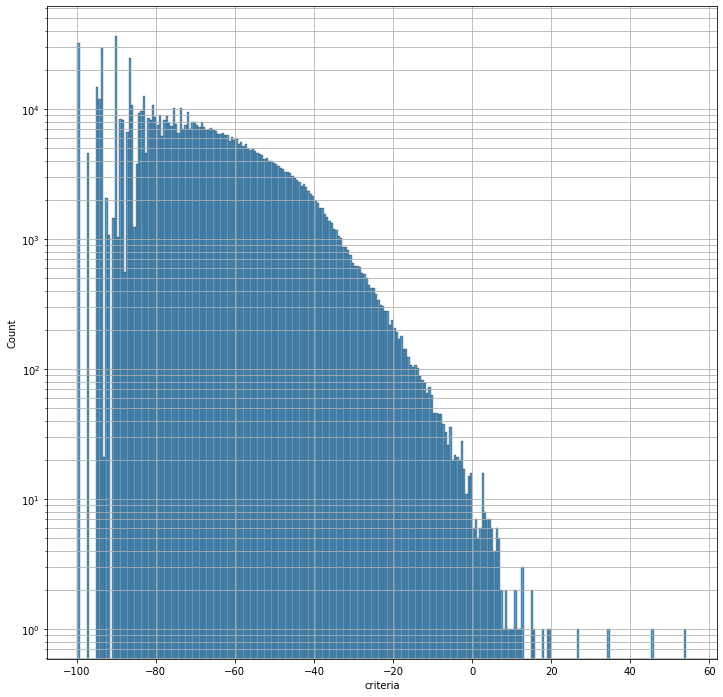

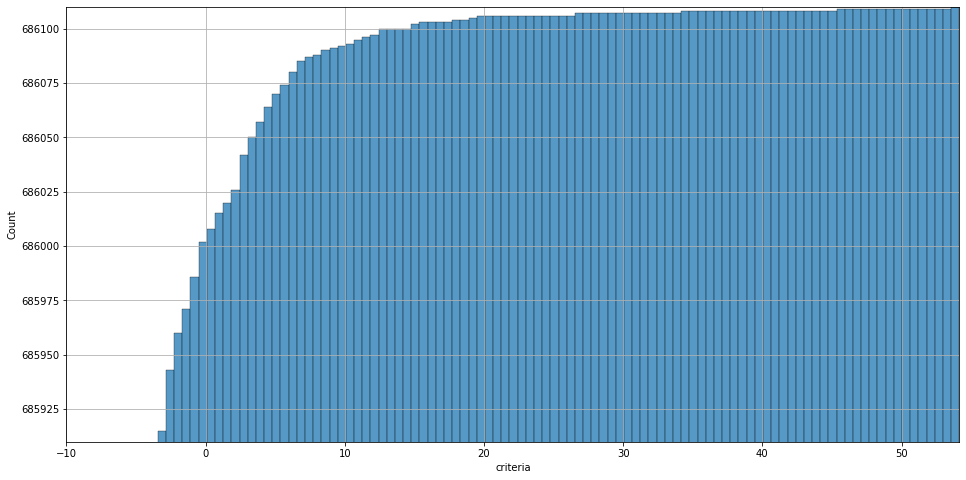

In [68]:
df = blobsdf

df['criteria'] = df.aspect_ratio - m * np.log10(df.area) - b
df['criteria2'] = df.aspect_ratio - m2 * np.log10(df.area) - b2
df = df.replace([np.inf, -np.inf], np.nan).dropna()

col = 'criteria'

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.histplot(df, x=col, ax=ax, )
ax.set_yscale('log')
ax.grid(True, which='both')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(df, x=col, ax=ax, cumulative=True)
# ax.set_yscale('log')
n_last = 200
ax.set_ylim(((n := df.shape[0]) - n_last, n))
ax.set_xlim(-10, df.criteria.max())
ax.grid(True, which='both')

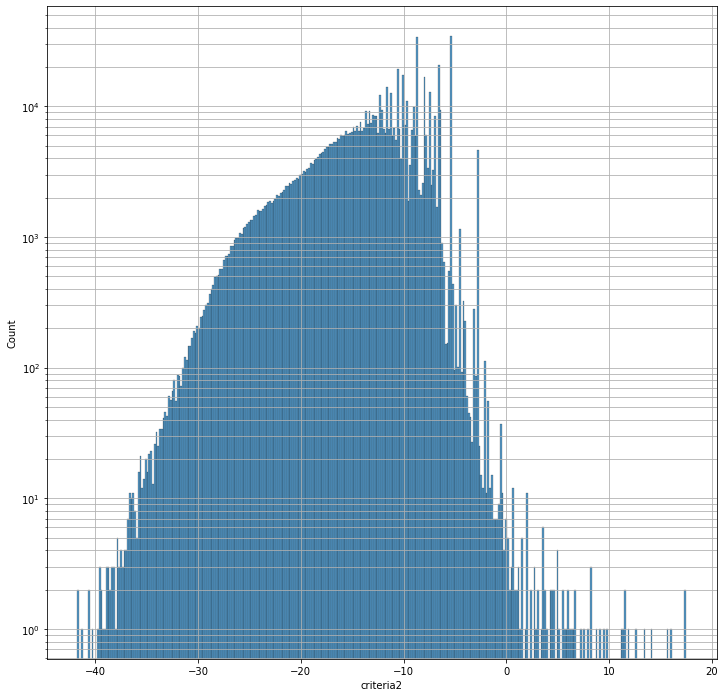

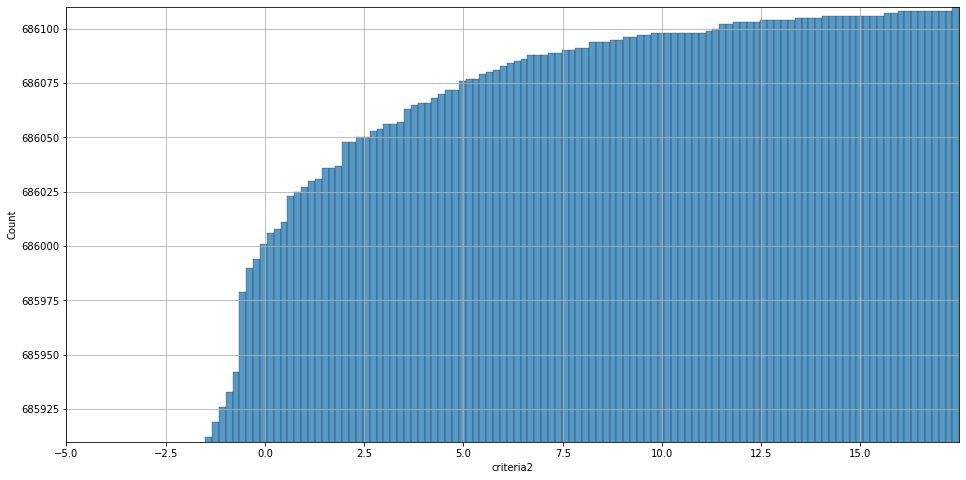

In [69]:
col = 'criteria2'

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.histplot(df, x=col, ax=ax, )
ax.set_yscale('log')
ax.grid(True, which='both')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(df, x=col, ax=ax, cumulative=True)
# ax.set_yscale('log')
n_last = 200
ax.set_ylim(((n := df.shape[0]) - n_last, n))
ax.set_xlim(-5, df.criteria2.max())
ax.grid(True, which='both')

# Find blobs based on the 2 criterion

In [78]:
blobs_blacklist = []

## Criteria1

In [84]:
bigcriteria1 = df[df.criteria >= 0]
bigcriteria1.shape

(111, 25)

In [76]:
pd.set_option("display.max_columns", 200)

In [140]:
# bigcriteria.sort_values(by="z", ascending=True)[["area", "z", "centroid-x", "centroid-y"]].T
bigcriteria.sort_values(by="z", ascending=True)[["z", "centroid-x", "centroid-y"]].T

index,8638,9084,11285,12110,29258,66207,66417,66562,66812,67194,75393,118541,118953,126710,145652,158803,165968,166416,181834,182319,182791,183256,184188,184548,231817,247006,249681,257303,260243,301162,301623,363388,369471,397925,399765,400651,401432,401844,402286,403977,407799,408218,412188,412556,423494,425022,429059,430596,435941,461682,461984,462294,487672,487995,488346,488677,502838,512593,513021,525550,527321,527785,559582,559990,561306,573744,574132,574504,576023,598544,599897,600353,633711,661313,680204,680624,681992,682013,684879,686166,694511,702183,719719,720064,720412,727079,729317,729684,730075,746846,748748,750869,763435,763437,763870,763877,764299,764294,764691,771332,773279,776004,776548,778632,788260,788778,790669,796061,796143,796553,796642
z,17,18,24,27,69,154,154,155,155,156,177,273,274,292,336,365,382,383,416,417,418,419,422,423,531,567,574,592,598,681,682,825,840,913,916,919,921,922,923,926,936,937,946,947,976,979,989,993,1006,1083,1084,1085,1157,1158,1159,1160,1196,1220,1221,1250,1254,1255,1337,1338,1342,1376,1377,1378,1382,1442,1445,1446,1527,1592,1638,1639,1642,1642,1648,1651,1671,1690,1736,1737,1738,1753,1759,1760,1761,1797,1800,1805,1832,1832,1833,1833,1834,1834,1835,1850,1854,1859,1860,1864,1882,1883,1887,1896,1896,1897,1897
centroid-x,746,744,1193,886,8,552,1264,545,1265,1266,1121,1283,1285,1219,574,1244,39,39,1154,1153,1152,1151,592,592,301,1022,1016,665,664,1277,1277,207,12,7,1262,4,13,16,21,1187,20,18,1230,1230,10,1203,734,520,1245,591,592,592,594,596,592,590,1042,674,676,1290,1251,1251,1144,1143,303,1259,1263,1265,1224,1131,1130,1129,1175,925,1165,1165,1199,1223,1158,1245,1055,591,162,162,163,1214,782,780,779,54,1234,728,1188,1199,1187,1199,1199,1187,1200,1153,949,1273,1273,1035,1242,1240,1178,1026,1202,1025,1204
centroid-y,555,556,451,175,644,615,479,611,464,430,516,721,751,966,360,720,549,552,307,285,257,240,375,377,988,628,612,154,130,209,214,445,987,856,882,937,929,951,982,607,554,543,340,338,931,560,956,414,975,407,406,406,592,593,592,591,676,797,798,789,321,323,577,565,948,1010,1019,1023,608,591,348,344,154,243,321,325,64,48,396,682,915,357,70,56,39,838,554,556,558,103,920,507,324,930,275,957,981,273,998,958,355,358,348,651,589,567,657,948,852,940,848


In [188]:
for idx in [
    # 1st round
    # 9084, 11285, 12110, 29258, 66207
    # 2nd round
    # redundancies: 66562, 66812, 67194, 118953, 166416
    # 66417, 75393, 118541, 126710, 145652, 158803, 165968, 181834, 
    # 3rd round
    # redundancies: 182319, 182791, 183256, 184548, 301623, 400651, 401844, 402286, 
    # 184188, 231817, 247006, 249681, 257303, 260243, 301162, 363388, 369471, 397925, 399765, 401432, 403977, 407799, 
    # 4th round
    # redundancies: 
    #      461984, 462294, 487995, 488346, 488677, 513021, 527785, 559990, 
    #      574132, 574504, 600353, 680624, 720064, 720412, 729684, 730075, 
    #      763877, 764299, 764294, 764691, 771332, 
    # NOT ring: 
    #      408218, 412188, 412556, 423494, 425022, 429059, 430596, 502838, 
    #      512593, 525550, 527321, 559582, 561306, 573744, 576023, 598544, 
    #      633711, 661313, 680204, 681992, 682013, 684879, 686166, 694511, 
    #      702183, 719719, 727079, 746846, 748748, 763435, 763437, 763870, 
    #      776004, 776548, 778632, 788260, 788778, 790669, 796061, 796143, 
    #      796553, 796642
    # IS ring: 
    #      435941, 461682, 487672, 599897, 729317, 750869, 773279, 
    435941, 461682, 487672, 599897, 729317, 750869, 773279, 
]:
    if idx is None:
        print(15 * "--")
        continue
    print(f"index={idx} --> is a ring")
    print(bigcriteria.loc[idx][["z", "centroid-x", "centroid-y"]].astype(int).to_json(indent=1)[2:-2])

index=435941 --> is a ring
 "z":1006,
 "centroid-x":1245,
 "centroid-y":975
index=461682 --> is a ring
 "z":1083,
 "centroid-x":591,
 "centroid-y":407
index=487672 --> is a ring
 "z":1157,
 "centroid-x":594,
 "centroid-y":592
index=599897 --> is a ring
 "z":1445,
 "centroid-x":1130,
 "centroid-y":348
index=729317 --> is a ring
 "z":1759,
 "centroid-x":782,
 "centroid-y":554
index=750869 --> is a ring
 "z":1805,
 "centroid-x":728,
 "centroid-y":507
index=773279 --> is a ring
 "z":1854,
 "centroid-x":949,
 "centroid-y":355
